# Лабораторна робота 4: Реалізація та Аналіз Дерев Рішень для Класифікації

**Датасет:** [Global Coffee Health Dataset](https://www.kaggle.com/datasets/uom190346a/global-coffee-health-dataset/data)

**Опис:** Датасет містить 10,000 синтетичних записів про споживання кави, сон та здоров'я.

**Цільова змінна:** `Health_Issues` (категоріальна: None, Mild, Moderate, Severe)

## Імпорт бібліотек

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, matthews_corrcoef, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy

# Налаштування для відображення графіків
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style("whitegrid")

## 0. Завантаження та Передобробка Даних

**Цільова змінна:** `Health_Issues` (None, Mild, Moderate, Severe)

**Кроки обробки:**
1. Видалення ID
2. Label Encoding для цільової змінної  
3. One-Hot Encoding для категоріальних ознак
4. Поділ даних на тренувальну та тестову вибірки (80/20)

In [2]:
# Завантаження датасету
try:
    df = pd.read_csv('synthetic_coffee_health_10000.csv')
    print(f"✓ Датасет завантажено: {df.shape}")
except FileNotFoundError:
    print("❌ Файл 'synthetic_coffee_health_10000.csv' не знайдено!")
    raise

# Видалення ID
df = df.drop('ID', axis=1)

# Обробка пропущених значень
df.dropna(inplace=True)
print(f"✓ Після видалення пропусків: {df.shape}")

# Кодування цільової змінної (Label Encoding)
le = LabelEncoder()
y = le.fit_transform(df['Health_Issues'])
class_names = le.classes_
print(f"\n✓ Класи: {class_names}")
print(f"✓ Розподіл класів:\n{pd.Series(y).value_counts().sort_index()}")

# Кодування категоріальних ознак (One-Hot Encoding)
categorical_cols = ['Gender', 'Country', 'Sleep_Quality', 'Stress_Level', 
                    'Occupation', 'Smoking', 'Alcohol_Consumption']

X = df.drop('Health_Issues', axis=1)
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Поділ даних на тренувальну та тестову вибірки (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y, test_size=0.2, random_state=42, stratify=y
)

feature_names = X.columns.tolist()

print(f"\n✓ Розмір тренувальної вибірки: {X_train.shape}")
print(f"✓ Розмір тестової вибірки: {X_test.shape}")
print(f"✓ Кількість ознак: {len(feature_names)}")

✓ Датасет завантажено: (10000, 16)
✓ Після видалення пропусків: (4059, 15)

✓ Класи: ['Mild' 'Moderate' 'Severe']
✓ Розподіл класів:
0    3579
1     463
2      17
Name: count, dtype: int64

✓ Розмір тренувальної вибірки: (3247, 39)
✓ Розмір тестової вибірки: (812, 39)
✓ Кількість ознак: 39


## а) Реалізація Дерева Рішень з Використанням Gini Index

### Теоретична основа

**Gini Index (Індекс Джіні)** вимірює неоднорідність вузла:

$$\text{Gini}(node) = 1 - \sum_{i=1}^{c} p_i^2$$

де $p_i$ — частка класу $i$ у вузлі, $c$ — кількість класів.

**Feature Importance** обчислюється як зважене зменшення Gini:

$$\text{Importance}_{Node_k} = \frac{n_k}{n_{total}} \cdot \left( \text{Gini}_k - \frac{n_{left}}{n_k} \cdot \text{Gini}_{left} - \frac{n_{right}}{n_k} \cdot \text{Gini}_{right} \right)$$

**Алгоритм побудови дерева:**
1. Обчислити Gini для поточного вузла
2. Якщо Gini = 0 або досягнуто критерій зупинки → листовий вузол
3. Для кожної ознаки та порогу обчислити зважений Gini після розділу
4. Обрати ознаку/поріг з мінімальним Gini
5. Оновити importance для обраної ознаки
6. Рекурсивно застосувати до піддерев

In [3]:
class MyDecisionTree:
    """
    Власна реалізація дерева рішень з використанням Gini Index.
    
    Parameters:
    -----------
    max_depth : int
        Максимальна глибина дерева
    min_samples : int
        Мінімальна кількість зразків для розділу вузла
    feature_count : int or None
        Кількість випадкових ознак для розгляду (для Random Forest)
    """
    
    def __init__(self, max_depth=5, min_samples=2, feature_count=None):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.feature_importance = None
        self.tree = None
        self.n_total = 0
        self.feature_count = feature_count

    def gini(self, y):
        """Розрахунок Gini impurity для вузла."""
        if len(y) == 0:
            return 0.0
        
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        
        return 1.0 - np.sum(probabilities**2)

    def best_split(self, X, y):
        """
        Пошук найкращого розділу за мінімальним зваженим Gini.
        
        Returns:
        --------
        best_feature : int
            Індекс найкращої ознаки
        best_threshold : float
            Найкращий поріг
        best_gini_weighted : float
            Зважений Gini після розділу
        best_split_idx : tuple
            (left_indices, right_indices, parent_gini)
        """
        m = X.shape[0]
        if m <= self.min_samples:
            return None, None, float('inf'), None
        
        current_gini = self.gini(y)
        best_gini_weighted = float('inf')
        best_feature, best_threshold = None, None
        best_split_idx = None

        # Вибір ознак для розгляду (всі або випадкова підмножина)
        features_to_check = (np.random.choice(X.shape[1], self.feature_count, replace=False) 
                            if self.feature_count is not None else range(X.shape[1]))

        for feature in features_to_check:
            thresholds = np.unique(X[:, feature])
            
            for threshold in thresholds:
                # Розділ даних
                left_indices = np.where(X[:, feature] <= threshold)[0]
                right_indices = np.where(X[:, feature] > threshold)[0]
                
                n_left, n_right = len(left_indices), len(right_indices)
                if n_left == 0 or n_right == 0:
                    continue
                
                # Обчислення зваженого Gini
                y_left, y_right = y[left_indices], y[right_indices]
                gini_left = self.gini(y_left)
                gini_right = self.gini(y_right)
                gini_weighted = (n_left * gini_left + n_right * gini_right) / m
                
                # Оновлення найкращого розділу
                if gini_weighted < best_gini_weighted:
                    best_gini_weighted = gini_weighted
                    best_feature = feature
                    best_threshold = threshold
                    best_split_idx = (left_indices, right_indices, current_gini)
                    
        return best_feature, best_threshold, best_gini_weighted, best_split_idx

    def majority_class(self, y):
        """Визначення класу більшості для листового вузла."""
        values, counts = np.unique(y, return_counts=True)
        return values[np.argmax(counts)]

    def build_tree(self, X, y, depth=0, n_total=None):
        """
        Рекурсивна побудова дерева.
        
        Returns:
        --------
        node : dict
            Словник, що представляє вузол дерева
        """
        m = X.shape[0]
        if n_total is None:
            n_total = m
        
        # Критерії зупинки
        if depth >= self.max_depth or m < self.min_samples or self.gini(y) == 0.0:
            return {'leaf': True, 'class': self.majority_class(y), 'n': m}

        # Пошук найкращого розділу
        feature, threshold, gini_weighted, split_idx = self.best_split(X, y)
        
        if feature is None:
            return {'leaf': True, 'class': self.majority_class(y), 'n': m}

        # Обчислення feature importance для даного вузла
        left_indices, right_indices, gini_parent = split_idx
        n_node = m
        
        # Importance = (n_node / n_total) * (Gini_parent - Gini_weighted)
        self.feature_importance[feature] += (n_node / self.n_total) * (gini_parent - gini_weighted)
        
        # Рекурсивна побудова піддерев
        left_subtree = self.build_tree(X[left_indices], y[left_indices], depth + 1, n_total)
        right_subtree = self.build_tree(X[right_indices], y[right_indices], depth + 1, n_total)

        return {
            'leaf': False,
            'feature': feature,
            'threshold': threshold,
            'n': m,
            'left': left_subtree,
            'right': right_subtree
        }

    def fit(self, X, y):
        """
        Навчає дерево та обчислює нормалізовану важливість ознак.
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Тренувальні дані
        y : array-like, shape (n_samples,)
            Цільові значення
            
        Returns:
        --------
        self : MyDecisionTree
        """
        self.n_total = len(y)
        self.feature_importance = np.zeros(X.shape[1])
        self.tree = self.build_tree(X, y)

        # Нормалізація важливості ознак
        sum_importance = np.sum(self.feature_importance)
        if sum_importance > 0:
            self.feature_importance /= sum_importance
        
        return self

    def predict_one(self, x, node=None):
        """Прогнозує клас для одного зразка."""
        if node is None:
            node = self.tree

        if node['leaf']:
            return node['class']
        
        if x[node['feature']] <= node['threshold']:
            return self.predict_one(x, node['left'])
        else:
            return self.predict_one(x, node['right'])

    def predict(self, X):
        """
        Прогнозує класи для всіх зразків.
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Дані для прогнозування
            
        Returns:
        --------
        y_pred : array, shape (n_samples,)
            Передбачені класи
        """
        return np.array([self.predict_one(x) for x in X])

print("✓ Клас MyDecisionTree створено")

✓ Клас MyDecisionTree створено


### Навчання та оцінка власної моделі

In [4]:
# Навчання власної моделі
print("🔄 Навчання MyDecisionTree...")
start_time = time.time()

tree = MyDecisionTree(max_depth=8, min_samples=10)
tree.fit(X_train, y_train)

training_time = time.time() - start_time

# Прогнозування
y_pred = tree.predict(X_test)

# Оцінка моделі
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

print("\n" + "="*60)
print("РЕЗУЛЬТАТИ: Власна Реалізація Decision Tree (MyDecisionTree)")
print("="*60)
print(f"Час навчання: {training_time:.4f} сек")
print(f"Точність (Accuracy): {accuracy:.4f}")
print(f"F1-score (Weighted): {f1:.4f}")
print(f"МСС (Matthews Correlation Coefficient): {mcc:.4f}")
print("="*60)

🔄 Навчання MyDecisionTree...

РЕЗУЛЬТАТИ: Власна Реалізація Decision Tree (MyDecisionTree)
Час навчання: 0.9574 сек
Точність (Accuracy): 0.9951
F1-score (Weighted): 0.9950
МСС (Matthews Correlation Coefficient): 0.9763

РЕЗУЛЬТАТИ: Власна Реалізація Decision Tree (MyDecisionTree)
Час навчання: 0.9574 сек
Точність (Accuracy): 0.9951
F1-score (Weighted): 0.9950
МСС (Matthews Correlation Coefficient): 0.9763


### Візуалізація: Confusion Matrix та Feature Importance

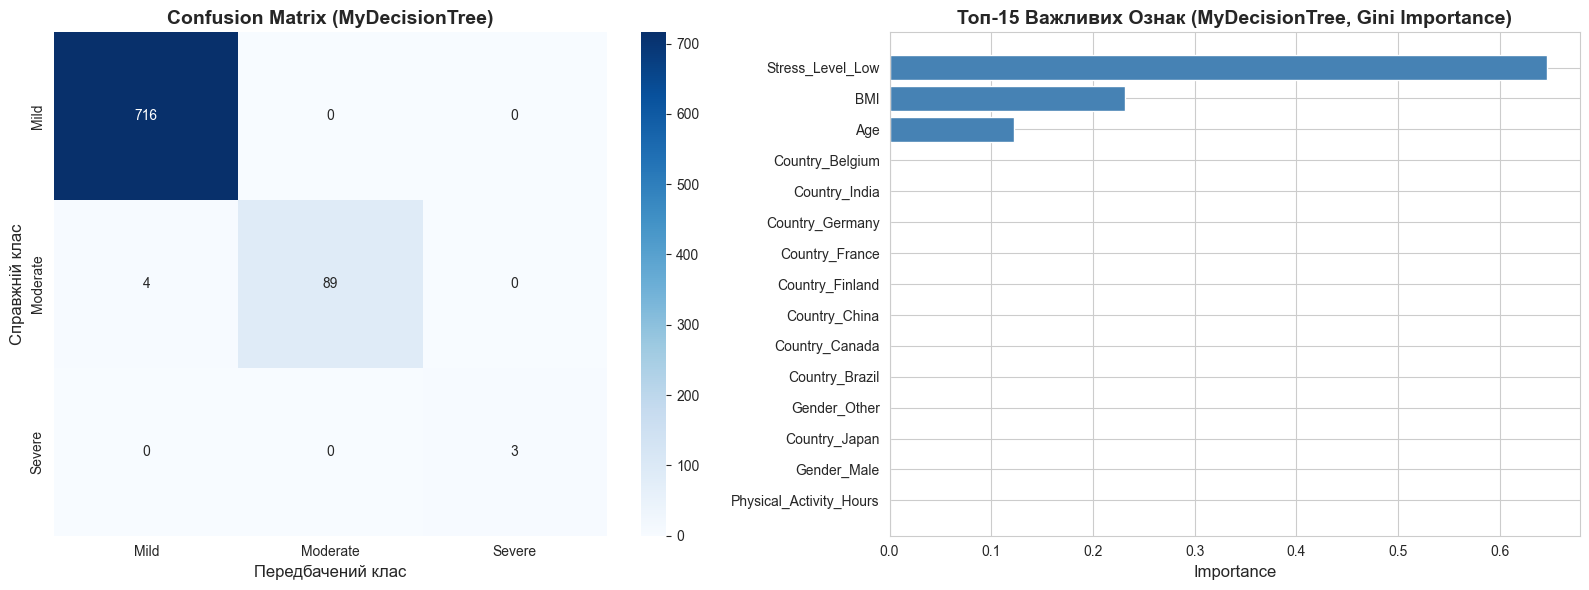


✓ Найважливіша ознака: Stress_Level_Low (importance: 0.6465)


In [5]:
# Створення фігури з двома підграфіками
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title('Confusion Matrix (MyDecisionTree)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Справжній клас', fontsize=12)
axes[0].set_xlabel('Передбачений клас', fontsize=12)

# 2. Feature Importance (топ-15)
importances = tree.feature_importance
sorted_idx = importances.argsort()[::-1][:15]  # Топ-15 ознак

axes[1].barh(range(len(sorted_idx)), importances[sorted_idx], color='steelblue')
axes[1].set_yticks(range(len(sorted_idx)))
axes[1].set_yticklabels([feature_names[i] for i in sorted_idx], fontsize=10)
axes[1].set_xlabel('Importance', fontsize=12)
axes[1].set_title('Топ-15 Важливих Ознак (MyDecisionTree, Gini Importance)', 
                  fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\n✓ Найважливіша ознака: {feature_names[sorted_idx[0]]} (importance: {importances[sorted_idx[0]]:.4f})")

## б) Реалізація Механізму Уникнення Перенавчання (Прунінг)

### Теоретична основа Cost-Complexity Pruning

**Мета:** Зменшити складність дерева для покращення узагальнення

**Формула Cost-Complexity:**

$$R_\alpha(T) = R(T) + \alpha \cdot |T|$$

де:
- $R(T)$ — помилка класифікації піддерева $T$
- $|T|$ — кількість листів у піддереві
- $\alpha$ — параметр складності (більше $\alpha$ → більше обрізка)

**Алгоритм:**
1. Побудувати повне дерево без обмежень
2. Для кожного піддерева обчислити $R_\alpha(T)$
3. Рекурсивно зливати вузли, якщо це зменшує $R_\alpha$
4. Підібрати оптимальне $\alpha$ за валідаційними даними
5. Застосувати прунінг та переобчислити feature importance

In [6]:
# Додавання методів прунінгу до класу MyDecisionTree
def count_leaves(self, node):
    """Підрахунок кількості листів у піддереві."""
    if node['leaf']:
        return 1
    return self.count_leaves(node['left']) + self.count_leaves(node['right'])

def calculate_error(self, X, y, node):
    """Обчислення помилки на валідаційних даних."""
    if node['leaf']:
        y_pred = np.full(len(y), node['class'])
    else:
        y_pred = np.array([self.predict_one(x, node) for x in X])
    
    return np.sum(y_pred != y) / len(y)

def prune_tree(self, node, alpha, X, y):
    """
    Рекурсивний Cost-complexity pruning.
    
    Parameters:
    -----------
    node : dict
        Поточний вузол дерева
    alpha : float
        Параметр складності
    X : array-like
        Валідаційні дані
    y : array-like
        Валідаційні мітки
        
    Returns:
    --------
    error : float
        Помилка піддерева
    """
    if node['leaf']:
        node['n_leaves'] = 1
        node['R'] = self.calculate_error(X, y, node)
        node['R_alpha'] = node['R'] + alpha * node['n_leaves']
        return node['R']

    # Рекурсивний прунінг піддерев
    left_error = self.prune_tree(node['left'], alpha, X, y)
    right_error = self.prune_tree(node['right'], alpha, X, y)
    
    subtree_error = left_error + right_error
    subtree_n_leaves = self.count_leaves(node['left']) + self.count_leaves(node['right'])

    # Створення листового вузла
    leaf_class = self.majority_class(y)
    leaf_node = {'leaf': True, 'class': leaf_class}
    leaf_error = self.calculate_error(X, y, leaf_node)
    
    # Порівняння вартості листа та піддерева
    cost_leaf = leaf_error + alpha * 1
    cost_subtree = subtree_error + alpha * subtree_n_leaves

    # Якщо лист краще → обрізаємо
    if cost_leaf <= cost_subtree:
        node['leaf'] = True
        node['class'] = leaf_class
        if 'left' in node: del node['left']
        if 'right' in node: del node['right']
        if 'feature' in node: del node['feature']
        if 'threshold' in node: del node['threshold']
        
        node['n_leaves'] = 1
        node['R'] = leaf_error
        node['R_alpha'] = cost_leaf
        return leaf_error
    else:
        node['n_leaves'] = subtree_n_leaves
        node['R'] = subtree_error
        node['R_alpha'] = cost_subtree
        return subtree_error

def refit_feature_importance(self, X, y):
    """Переобчислення feature importance після прунінгу."""
    self.n_total = len(y)
    self.feature_importance = np.zeros(X.shape[1])
    self._recalc_importance(self.tree, X, y)
    
    sum_importance = np.sum(self.feature_importance)
    if sum_importance > 0:
        self.feature_importance /= sum_importance
        
def _recalc_importance(self, node, X, y):
    """Рекурсивна функція для переобчислення importance."""
    if node['leaf']:
        return
    
    gini_parent = self.gini(y)
    feature = node['feature']
    threshold = node['threshold']
    
    left_indices = np.where(X[:, feature] <= threshold)[0]
    right_indices = np.where(X[:, feature] > threshold)[0]
    
    n_left, n_right = len(left_indices), len(right_indices)
    n_node = len(y)
    
    if n_left > 0 and n_right > 0:
        y_left, y_right = y[left_indices], y[right_indices]
        gini_left = self.gini(y_left)
        gini_right = self.gini(y_right)
        
        gini_weighted = (n_left * gini_left + n_right * gini_right) / n_node
        self.feature_importance[feature] += (n_node / self.n_total) * (gini_parent - gini_weighted)
        
        self._recalc_importance(node['left'], X[left_indices], y[left_indices])
        self._recalc_importance(node['right'], X[right_indices], y[right_indices])

# Додавання методів до класу
MyDecisionTree.count_leaves = count_leaves
MyDecisionTree.calculate_error = calculate_error
MyDecisionTree.prune_tree = prune_tree
MyDecisionTree.refit_feature_importance = refit_feature_importance
MyDecisionTree._recalc_importance = _recalc_importance

print("✓ Методи прунінгу додано до MyDecisionTree")

✓ Методи прунінгу додано до MyDecisionTree


### Пошук оптимального параметра α

🔄 Побудова повного дерева для прунінгу...
✓ Повне дерево побудовано: 10 листів

🔍 Пошук оптимального α...

✓ Оптимальне α: 0.0000
✓ Найкраща точність на валідації: 0.8815
✓ Повне дерево побудовано: 10 листів

🔍 Пошук оптимального α...

✓ Оптимальне α: 0.0000
✓ Найкраща точність на валідації: 0.8815


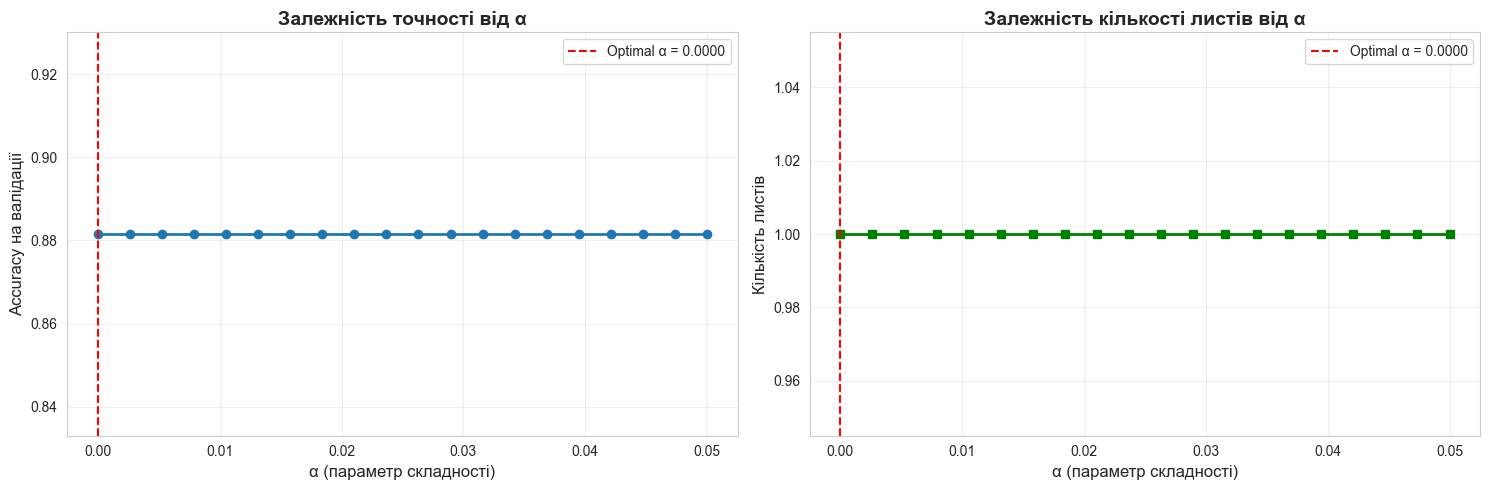

In [7]:
# Створення валідаційної вибірки для підбору α
print("🔄 Побудова повного дерева для прунінгу...")
X_train_prune, X_val_prune, y_train_prune, y_val_prune = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Побудова повного дерева без обмежень
full_tree = MyDecisionTree(max_depth=15, min_samples=1)
full_tree.fit(X_train_prune, y_train_prune)

print(f"✓ Повне дерево побудовано: {full_tree.count_leaves(full_tree.tree)} листів")

# Тестування різних значень α
print("\n🔍 Пошук оптимального α...")
alphas = np.linspace(0, 0.05, 20)
results = []

for alpha in alphas:
    # Створення копії дерева для прунінгу
    pruned_tree_temp = MyDecisionTree(max_depth=15, min_samples=1)
    pruned_tree_temp.tree = copy.deepcopy(full_tree.tree)
    pruned_tree_temp.n_total = full_tree.n_total
    pruned_tree_temp.feature_importance = full_tree.feature_importance.copy()
    
    # Застосування прунінгу
    pruned_tree_temp.prune_tree(pruned_tree_temp.tree, alpha, X_val_prune, y_val_prune)
    
    # Оцінка на валідаційних даних
    y_val_pred = pruned_tree_temp.predict(X_val_prune)
    val_acc = accuracy_score(y_val_prune, y_val_pred)
    n_leaves = pruned_tree_temp.count_leaves(pruned_tree_temp.tree)
    
    results.append({
        'alpha': alpha,
        'accuracy': val_acc,
        'leaves': n_leaves
    })

results_df = pd.DataFrame(results)
optimal_alpha = results_df.loc[results_df['accuracy'].idxmax()]['alpha']

print(f"\n✓ Оптимальне α: {optimal_alpha:.4f}")
print(f"✓ Найкраща точність на валідації: {results_df['accuracy'].max():.4f}")

# Візуалізація результатів
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Графік точності vs α
axes[0].plot(results_df['alpha'], results_df['accuracy'], 'o-', linewidth=2, markersize=6)
axes[0].axvline(optimal_alpha, color='red', linestyle='--', label=f'Optimal α = {optimal_alpha:.4f}')
axes[0].set_xlabel('α (параметр складності)', fontsize=12)
axes[0].set_ylabel('Accuracy на валідації', fontsize=12)
axes[0].set_title('Залежність точності від α', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Графік кількості листів vs α
axes[1].plot(results_df['alpha'], results_df['leaves'], 's-', color='green', linewidth=2, markersize=6)
axes[1].axvline(optimal_alpha, color='red', linestyle='--', label=f'Optimal α = {optimal_alpha:.4f}')
axes[1].set_xlabel('α (параметр складності)', fontsize=12)
axes[1].set_ylabel('Кількість листів', fontsize=12)
axes[1].set_title('Залежність кількості листів від α', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Застосування прунінгу та оцінка результатів

In [8]:
# Застосування прунінгу з оптимальним α
print("🔄 Застосування прунінгу з оптимальним α...")
final_pruned_tree = MyDecisionTree(max_depth=15, min_samples=1)
final_pruned_tree.tree = copy.deepcopy(full_tree.tree)
final_pruned_tree.n_total = full_tree.n_total
final_pruned_tree.feature_importance = np.zeros(X_train.shape[1])

final_pruned_tree.prune_tree(final_pruned_tree.tree, optimal_alpha, X_val_prune, y_val_prune)

# Переобчислення feature importance
final_pruned_tree.refit_feature_importance(X_train, y_train)

# Прогнозування на тестовій вибірці
y_pred_pruned = final_pruned_tree.predict(X_test)

# Оцінка моделі після прунінгу
accuracy_pruned = accuracy_score(y_test, y_pred_pruned)
f1_pruned = f1_score(y_test, y_pred_pruned, average='weighted')
mcc_pruned = matthews_corrcoef(y_test, y_pred_pruned)

print("\n" + "="*60)
print("РЕЗУЛЬТАТИ: Decision Tree після Прунінгу")
print("="*60)
print(f"Кількість листів ДО прунінгу: {full_tree.count_leaves(full_tree.tree)}")
print(f"Кількість листів ПІСЛЯ прунінгу: {final_pruned_tree.count_leaves(final_pruned_tree.tree)}")
print(f"Оптимальне α: {optimal_alpha:.4f}")
print(f"\nТочність (Accuracy) на тесті: {accuracy_pruned:.4f}")
print(f"F1-score (Weighted) на тесті: {f1_pruned:.4f}")
print(f"МСС (Matthews Correlation Coefficient): {mcc_pruned:.4f}")
print("="*60)

# Порівняння з моделлю без прунінгу
print("\n📊 Порівняння моделі до та після прунінгу:")
print(f"  Точність БЕЗ прунінгу: {accuracy:.4f}")
print(f"  Точність З прунінгом: {accuracy_pruned:.4f}")
print(f"  Зміна: {(accuracy_pruned - accuracy)*100:+.2f}%")

🔄 Застосування прунінгу з оптимальним α...

РЕЗУЛЬТАТИ: Decision Tree після Прунінгу
Кількість листів ДО прунінгу: 10
Кількість листів ПІСЛЯ прунінгу: 1
Оптимальне α: 0.0000

Точність (Accuracy) на тесті: 0.8818
F1-score (Weighted) на тесті: 0.8264
МСС (Matthews Correlation Coefficient): 0.0000

📊 Порівняння моделі до та після прунінгу:
  Точність БЕЗ прунінгу: 0.9951
  Точність З прунінгом: 0.8818
  Зміна: -11.33%


## в) Порівняння Результатів з sklearn DecisionTree та RandomForest

### Теоретична основа

**DecisionTreeClassifier (sklearn):**
- Оптимізована C/C++ реалізація алгоритму CART
- Підтримує різні критерії розділу (Gini, Entropy)
- Швидше навчання порівняно з Python реалізацією

**RandomForestClassifier (sklearn):**
- Ансамбль із багатьох дерев рішень
- **Bootstrapping:** кожне дерево навчається на випадковій підвибірці даних
- **Random Feature Selection:** для кожного розділу розглядається випадкова підмножина ознак
- Зменшує variance через averaging
- Часто показує кращі результати порівняно з одним деревом

In [9]:
# 1. Навчання sklearn DecisionTreeClassifier
print("🔄 Навчання sklearn DecisionTreeClassifier...")
dt_sk = DecisionTreeClassifier(criterion='gini', max_depth=8, min_samples_leaf=10, random_state=42)
start_time_dt = time.time()
dt_sk.fit(X_train, y_train)
time_dt = time.time() - start_time_dt

y_pred_dt = dt_sk.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')
mcc_dt = matthews_corrcoef(y_test, y_pred_dt)

print(f"✓ Навчання завершено за {time_dt:.4f} сек")

# 2. Навчання RandomForestClassifier
print("\n🔄 Навчання RandomForestClassifier...")
rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=8, 
                            min_samples_leaf=10, random_state=42, n_jobs=-1)
start_time_rf = time.time()
rf.fit(X_train, y_train)
time_rf = time.time() - start_time_rf

y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
mcc_rf = matthews_corrcoef(y_test, y_pred_rf)

print(f"✓ Навчання завершено за {time_rf:.4f} сек")

# 3. Створення таблиці порівняння
comparison = pd.DataFrame({
    'Модель': ['MyDecisionTree', 'sklearn DecisionTree', 'RandomForest'],
    'Accuracy': [accuracy, acc_dt, acc_rf],
    'F1-score': [f1, f1_dt, f1_rf],
    'MCC': [mcc, mcc_dt, mcc_rf],
    'Час навчання (сек)': [training_time, time_dt, time_rf]
})

print("\n" + "="*80)
print("ПОРІВНЯЛЬНА ТАБЛИЦЯ МОДЕЛЕЙ")
print("="*80)
print(comparison.to_string(index=False))
print("="*80)

# Виділення найкращої моделі
best_model_idx = comparison['Accuracy'].idxmax()
best_model_name = comparison.loc[best_model_idx, 'Модель']
print(f"\n🏆 Найкраща модель за точністю: {best_model_name} ({comparison.loc[best_model_idx, 'Accuracy']:.4f})")

🔄 Навчання sklearn DecisionTreeClassifier...
✓ Навчання завершено за 0.0130 сек

🔄 Навчання RandomForestClassifier...
✓ Навчання завершено за 0.1406 сек

ПОРІВНЯЛЬНА ТАБЛИЦЯ МОДЕЛЕЙ
              Модель  Accuracy  F1-score      MCC  Час навчання (сек)
      MyDecisionTree  0.995074  0.995027 0.976319            0.957429
sklearn DecisionTree  0.996305  0.996314 0.982448            0.012993
        RandomForest  0.979064  0.976642 0.896418            0.140589

🏆 Найкраща модель за точністю: sklearn DecisionTree (0.9963)
✓ Навчання завершено за 0.1406 сек

ПОРІВНЯЛЬНА ТАБЛИЦЯ МОДЕЛЕЙ
              Модель  Accuracy  F1-score      MCC  Час навчання (сек)
      MyDecisionTree  0.995074  0.995027 0.976319            0.957429
sklearn DecisionTree  0.996305  0.996314 0.982448            0.012993
        RandomForest  0.979064  0.976642 0.896418            0.140589

🏆 Найкраща модель за точністю: sklearn DecisionTree (0.9963)


### Порівняння Feature Importance

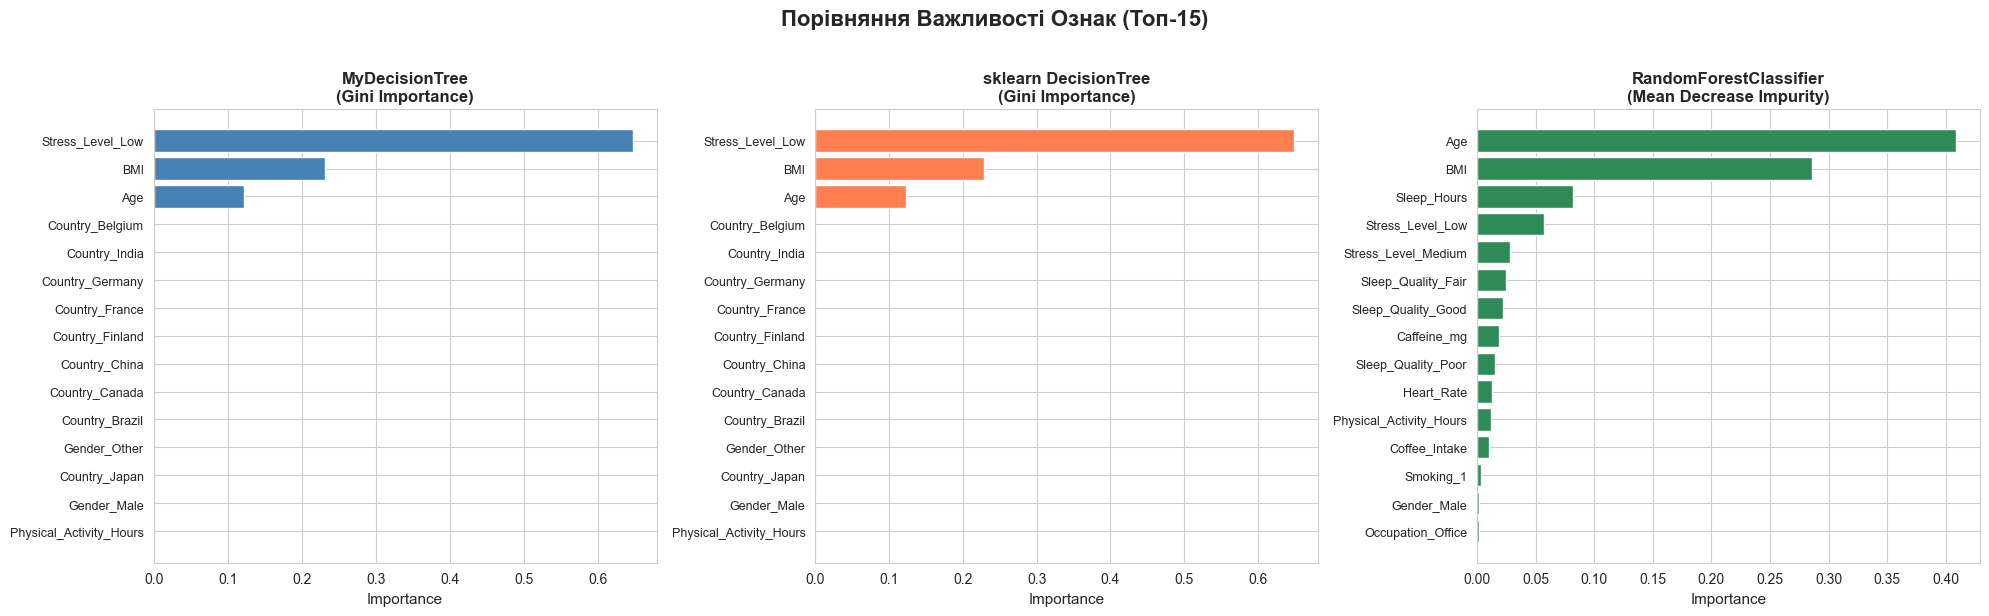


📊 Аналіз Feature Importance:
  MyDecisionTree найважливіша ознака: Stress_Level_Low
  sklearn DT найважливіша ознака: Stress_Level_Low
  RandomForest найважливіша ознака: Age


In [10]:
# Порівняння Feature Importance між моделями
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. MyDecisionTree
importances_my = tree.feature_importance
sorted_idx_my = importances_my.argsort()[::-1][:15]
axes[0].barh(range(len(sorted_idx_my)), importances_my[sorted_idx_my], color='steelblue')
axes[0].set_yticks(range(len(sorted_idx_my)))
axes[0].set_yticklabels([feature_names[i] for i in sorted_idx_my], fontsize=9)
axes[0].set_xlabel('Importance', fontsize=11)
axes[0].set_title('MyDecisionTree\n(Gini Importance)', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()

# 2. sklearn DecisionTree
importances_dt = dt_sk.feature_importances_
sorted_idx_dt = importances_dt.argsort()[::-1][:15]
axes[1].barh(range(len(sorted_idx_dt)), importances_dt[sorted_idx_dt], color='coral')
axes[1].set_yticks(range(len(sorted_idx_dt)))
axes[1].set_yticklabels([feature_names[i] for i in sorted_idx_dt], fontsize=9)
axes[1].set_xlabel('Importance', fontsize=11)
axes[1].set_title('sklearn DecisionTree\n(Gini Importance)', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()

# 3. RandomForest
importances_rf = rf.feature_importances_
sorted_idx_rf = importances_rf.argsort()[::-1][:15]
axes[2].barh(range(len(sorted_idx_rf)), importances_rf[sorted_idx_rf], color='seagreen')
axes[2].set_yticks(range(len(sorted_idx_rf)))
axes[2].set_yticklabels([feature_names[i] for i in sorted_idx_rf], fontsize=9)
axes[2].set_xlabel('Importance', fontsize=11)
axes[2].set_title('RandomForestClassifier\n(Mean Decrease Impurity)', fontsize=12, fontweight='bold')
axes[2].invert_yaxis()

plt.suptitle('Порівняння Важливості Ознак (Топ-15)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n📊 Аналіз Feature Importance:")
print(f"  MyDecisionTree найважливіша ознака: {feature_names[sorted_idx_my[0]]}")
print(f"  sklearn DT найважливіша ознака: {feature_names[sorted_idx_dt[0]]}")
print(f"  RandomForest найважливіша ознака: {feature_names[sorted_idx_rf[0]]}")

### Крос-валідація (5-fold)

🔄 Виконання 5-fold крос-валідації...

РЕЗУЛЬТАТИ КРОС-ВАЛІДАЦІЇ (5-fold)
sklearn DecisionTree:
  Середня точність: 0.9975
  Стандартне відхилення: 0.0016
  Діапазон: [0.9954, 1.0000]

RandomForest:
  Середня точність: 0.9837
  Стандартне відхилення: 0.0021
  Діапазон: [0.9800, 0.9862]

РЕЗУЛЬТАТИ КРОС-ВАЛІДАЦІЇ (5-fold)
sklearn DecisionTree:
  Середня точність: 0.9975
  Стандартне відхилення: 0.0016
  Діапазон: [0.9954, 1.0000]

RandomForest:
  Середня точність: 0.9837
  Стандартне відхилення: 0.0021
  Діапазон: [0.9800, 0.9862]


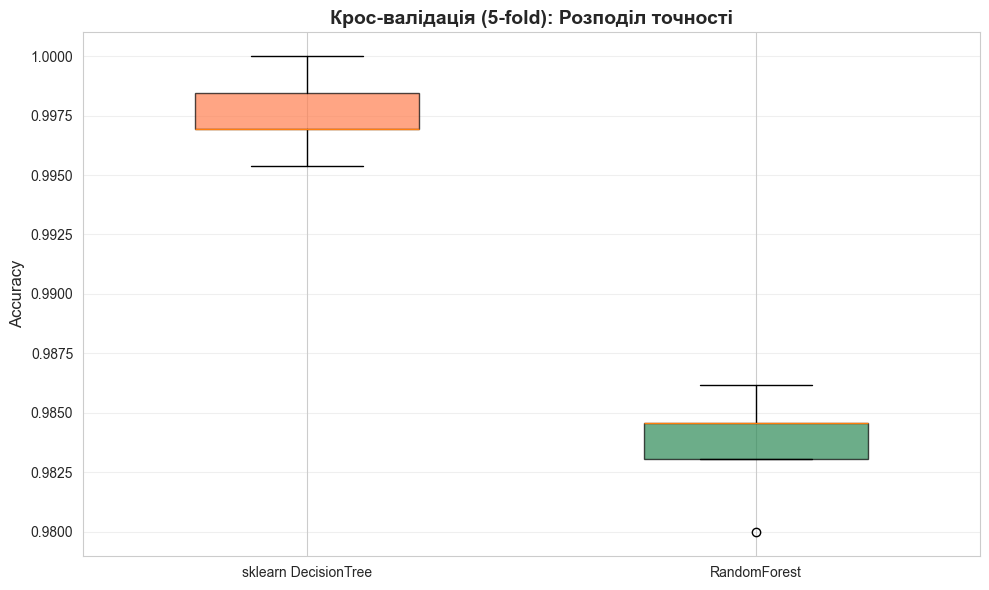

In [11]:
# Крос-валідація для бібліотечних моделей
print("🔄 Виконання 5-fold крос-валідації...")

cv_scores_dt = cross_val_score(dt_sk, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
cv_scores_rf = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

print("\n" + "="*60)
print("РЕЗУЛЬТАТИ КРОС-ВАЛІДАЦІЇ (5-fold)")
print("="*60)
print(f"sklearn DecisionTree:")
print(f"  Середня точність: {cv_scores_dt.mean():.4f}")
print(f"  Стандартне відхилення: {cv_scores_dt.std():.4f}")
print(f"  Діапазон: [{cv_scores_dt.min():.4f}, {cv_scores_dt.max():.4f}]")
print(f"\nRandomForest:")
print(f"  Середня точність: {cv_scores_rf.mean():.4f}")
print(f"  Стандартне відхилення: {cv_scores_rf.std():.4f}")
print(f"  Діапазон: [{cv_scores_rf.min():.4f}, {cv_scores_rf.max():.4f}]")
print("="*60)

# Візуалізація результатів крос-валідації
fig, ax = plt.subplots(figsize=(10, 6))

positions = [1, 2]
bp = ax.boxplot([cv_scores_dt, cv_scores_rf], positions=positions, widths=0.5,
                 patch_artist=True, labels=['sklearn DecisionTree', 'RandomForest'])

colors = ['coral', 'seagreen']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Крос-валідація (5-fold): Розподіл точності', fontsize=14, fontweight='bold')
ax.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## д) Інженерія Ознак та Feature Selection

### Теоретична основа

**Інженерія ознак** покращує якість даних через створення інформативних змінних:

1. **Видалення колінеарних ознак** — якщо $|corr(f_1, f_2)| > 0.8$, видалити одну з них
2. **Створення взаємодій** — $f_{new} = f_1 \times f_2$ (наприклад, `Coffee_Intake * Sleep_Hours`)
3. **Бінінг** — розбиття неперервних змінних на категорії (наприклад, Age → Young/Middle/Old)
4. **Нормалізація** — $z = \frac{x - \mu}{\sigma}$ для числових ознак

**Feature Selection** обирає релевантні ознаки:
- **Gini-based selection:** топ-k ознак за feature importance
- **Permutation importance:** важливість через вплив на точність при перемішуванні ознаки
- Зменшує розмірність та шум

In [12]:
# Завантаження свіжих даних для інженерії ознак
print("🔄 Інженерія ознак...")
df_eng = pd.read_csv('synthetic_coffee_health_10000.csv').drop('ID', axis=1)
df_eng.dropna(inplace=True)

# 1. ВИДАЛЕННЯ КОЛІНЕАРНИХ ОЗНАК
print("\n1️⃣ Аналіз кореляцій...")
numerical_cols = df_eng.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove('Health_Issues') if 'Health_Issues' in numerical_cols else None

corr_matrix = df_eng[numerical_cols].corr()
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
            
if high_corr_pairs:
    print(f"   Знайдено {len(high_corr_pairs)} пар(и) з високою кореляцією:")
    for col1, col2, corr_val in high_corr_pairs:
        print(f"   - {col1} ↔ {col2}: {corr_val:.3f}")
        df_eng.drop(col2, axis=1, inplace=True)
        print(f"     ✓ Видалено '{col2}'")
else:
    print("   ✓ Високих кореляцій не знайдено")

# 2. СТВОРЕННЯ НОВИХ ОЗНАК
print("\n2️⃣ Створення нових ознак...")

# Взаємодія: Coffee_Intake * Sleep_Hours
df_eng['Coffee_Sleep_Interaction'] = df_eng['Coffee_Intake'] * df_eng['Sleep_Hours']
print("   ✓ Створено: Coffee_Sleep_Interaction")

# Поліноміальна ознака: BMI^2
df_eng['BMI_Squared'] = df_eng['BMI'] ** 2
print("   ✓ Створено: BMI_Squared")

# Бінінг: Age → Young/Middle/Old
df_eng['Age_Binned'] = pd.cut(df_eng['Age'], bins=[18, 30, 50, 80], 
                               labels=['Young', 'Middle', 'Old'], right=False)
print("   ✓ Створено: Age_Binned (Young/Middle/Old)")

# 3. КОДУВАННЯ
print("\n3️⃣ Кодування змінних...")
y_eng = le.fit_transform(df_eng['Health_Issues'])

X_eng = df_eng.drop('Health_Issues', axis=1)
categorical_cols_eng = ['Gender', 'Country', 'Sleep_Quality', 'Stress_Level', 
                        'Occupation', 'Smoking', 'Alcohol_Consumption', 'Age_Binned']
X_eng = pd.get_dummies(X_eng, columns=categorical_cols_eng, drop_first=True)
print(f"   ✓ One-Hot Encoding застосовано, кількість ознак: {X_eng.shape[1]}")

# 4. НОРМАЛІЗАЦІЯ
print("\n4️⃣ Нормалізація числових ознак...")
continuous_cols_eng = ['Age', 'Coffee_Intake', 'Sleep_Hours', 'BMI', 
                       'Heart_Rate', 'Physical_Activity_Hours', 
                       'Coffee_Sleep_Interaction', 'BMI_Squared']

scaler = StandardScaler()
X_eng[continuous_cols_eng] = scaler.fit_transform(X_eng[continuous_cols_eng])
print(f"   ✓ Нормалізовано {len(continuous_cols_eng)} ознак (z-score)")

# Поділ на train/test
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(
    X_eng.values, y_eng, test_size=0.2, random_state=42, stratify=y_eng
)

feature_names_eng = X_eng.columns.tolist()

print(f"\n✓ Фінальний датасет: {X_train_eng.shape[0]} train, {X_test_eng.shape[0]} test, {X_eng.shape[1]} ознак")

🔄 Інженерія ознак...

1️⃣ Аналіз кореляцій...
   Знайдено 1 пар(и) з високою кореляцією:
   - Coffee_Intake ↔ Caffeine_mg: 1.000
     ✓ Видалено 'Caffeine_mg'

2️⃣ Створення нових ознак...
   ✓ Створено: Coffee_Sleep_Interaction
   ✓ Створено: BMI_Squared
   ✓ Створено: Age_Binned (Young/Middle/Old)

3️⃣ Кодування змінних...
   ✓ One-Hot Encoding застосовано, кількість ознак: 42

4️⃣ Нормалізація числових ознак...
   ✓ Нормалізовано 8 ознак (z-score)

✓ Фінальний датасет: 3247 train, 812 test, 42 ознак


### Feature Selection: Відбір топ-k ознак

🔄 Відбір найважливіших ознак...

✓ Відібрано топ-15 ознак за Gini Importance:
   1. Stress_Level_Low: 0.6465
   2. BMI: 0.2316
   3. Age: 0.1219
   4. Country_Belgium: 0.0000
   5. Country_India: 0.0000
   6. Country_Germany: 0.0000
   7. Country_France: 0.0000
   8. Country_Finland: 0.0000
   9. Country_China: 0.0000
   10. Country_Canada: 0.0000
   11. Country_Brazil: 0.0000
   12. Gender_Male: 0.0000
   13. Gender_Other: 0.0000
   14. Country_Japan: 0.0000
   15. BMI_Squared: 0.0000

✓ Розмір датасету після feature selection: (3247, 15)

✓ Відібрано топ-15 ознак за Gini Importance:
   1. Stress_Level_Low: 0.6465
   2. BMI: 0.2316
   3. Age: 0.1219
   4. Country_Belgium: 0.0000
   5. Country_India: 0.0000
   6. Country_Germany: 0.0000
   7. Country_France: 0.0000
   8. Country_Finland: 0.0000
   9. Country_China: 0.0000
   10. Country_Canada: 0.0000
   11. Country_Brazil: 0.0000
   12. Gender_Male: 0.0000
   13. Gender_Other: 0.0000
   14. Country_Japan: 0.0000
   15. BMI_Squared: 0.

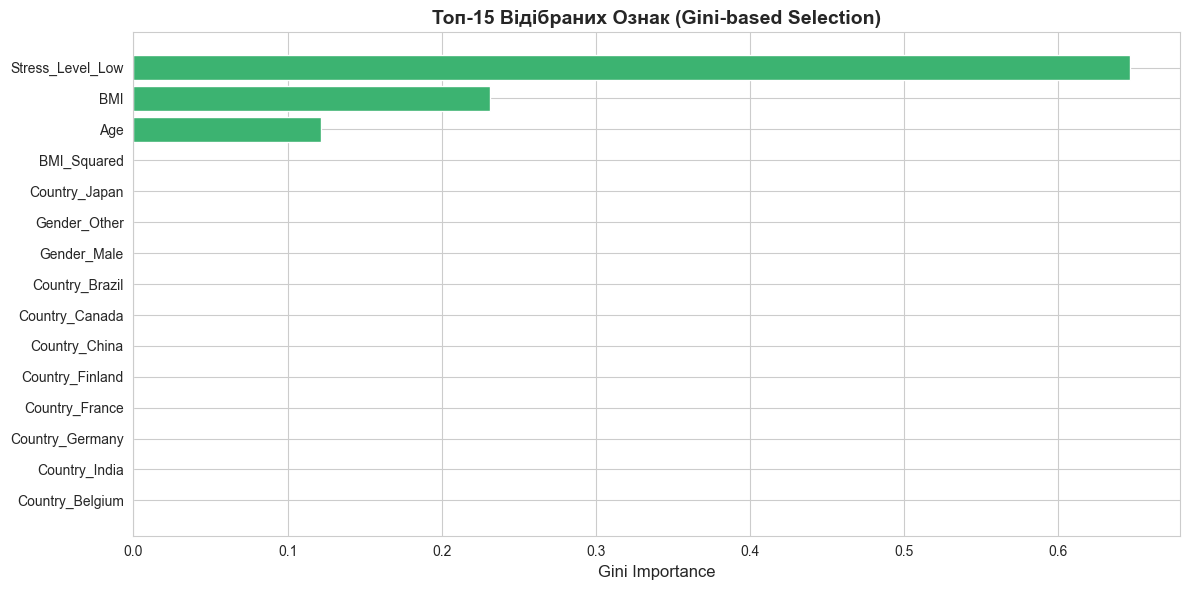

In [13]:
# Feature Selection за Gini importance
print("🔄 Відбір найважливіших ознак...")

tree_eng = MyDecisionTree(max_depth=10, min_samples=10)
tree_eng.fit(X_train_eng, y_train_eng)
importances_eng = tree_eng.feature_importance

# Відбір топ-15 ознак
k = 15
selected_indices = np.argsort(importances_eng)[-k:]
selected_features = [feature_names_eng[i] for i in selected_indices]

print(f"\n✓ Відібрано топ-{k} ознак за Gini Importance:")
for i, (idx, feat) in enumerate(zip(selected_indices[::-1], selected_features[::-1]), 1):
    print(f"   {i}. {feat}: {importances_eng[idx]:.4f}")

# Створення датасету з відібраними ознаками
X_train_selected = X_train_eng[:, selected_indices]
X_test_selected = X_test_eng[:, selected_indices]

print(f"\n✓ Розмір датасету після feature selection: {X_train_selected.shape}")

# Візуалізація важливості відібраних ознак
fig, ax = plt.subplots(figsize=(12, 6))
sorted_selected = sorted(zip(selected_features, importances_eng[selected_indices]), 
                        key=lambda x: x[1], reverse=True)
features_sorted = [x[0] for x in sorted_selected]
importance_sorted = [x[1] for x in sorted_selected]

ax.barh(range(len(features_sorted)), importance_sorted, color='mediumseagreen')
ax.set_yticks(range(len(features_sorted)))
ax.set_yticklabels(features_sorted, fontsize=10)
ax.set_xlabel('Gini Importance', fontsize=12)
ax.set_title(f'Топ-{k} Відібраних Ознак (Gini-based Selection)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

### Навчання моделі на відібраних ознаках

In [14]:
# Навчання RandomForest на відібраних ознаках
print("🔄 Навчання RandomForest на відібраних ознаках...")
rf_selected = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=10,
                                     random_state=42, n_jobs=-1)
rf_selected.fit(X_train_selected, y_train_eng)
y_pred_selected = rf_selected.predict(X_test_selected)

acc_selected = accuracy_score(y_test_eng, y_pred_selected)
f1_selected = f1_score(y_test_eng, y_pred_selected, average='weighted')
mcc_selected = matthews_corrcoef(y_test_eng, y_pred_selected)

print("\n" + "="*60)
print("РЕЗУЛЬТАТИ: RandomForest на відібраних ознаках")
print("="*60)
print(f"Кількість ознак: {k} (з {len(feature_names_eng)})")
print(f"Accuracy: {acc_selected:.4f}")
print(f"F1-score: {f1_selected:.4f}")
print(f"MCC: {mcc_selected:.4f}")
print("="*60)

# Порівняння з повним датасетом
print("\n📊 Порівняння результатів:")
print(f"  Accuracy (всі ознаки): {acc_rf:.4f}")
print(f"  Accuracy (відібрані {k} ознак): {acc_selected:.4f}")
print(f"  Зміна: {(acc_selected - acc_rf)*100:+.2f}%")
print(f"  Зменшення ознак: {len(feature_names_eng)} → {k} ({(1-k/len(feature_names_eng))*100:.1f}% редукція)")

🔄 Навчання RandomForest на відібраних ознаках...

РЕЗУЛЬТАТИ: RandomForest на відібраних ознаках
Кількість ознак: 15 (з 42)
Accuracy: 0.9963
F1-score: 0.9963
MCC: 0.9823

📊 Порівняння результатів:
  Accuracy (всі ознаки): 0.9791
  Accuracy (відібрані 15 ознак): 0.9963
  Зміна: +1.72%
  Зменшення ознак: 42 → 15 (64.3% редукція)


### Permutation Importance

🔄 Обчислення Permutation Importance...
✓ Permutation Importance обчислено
✓ Permutation Importance обчислено


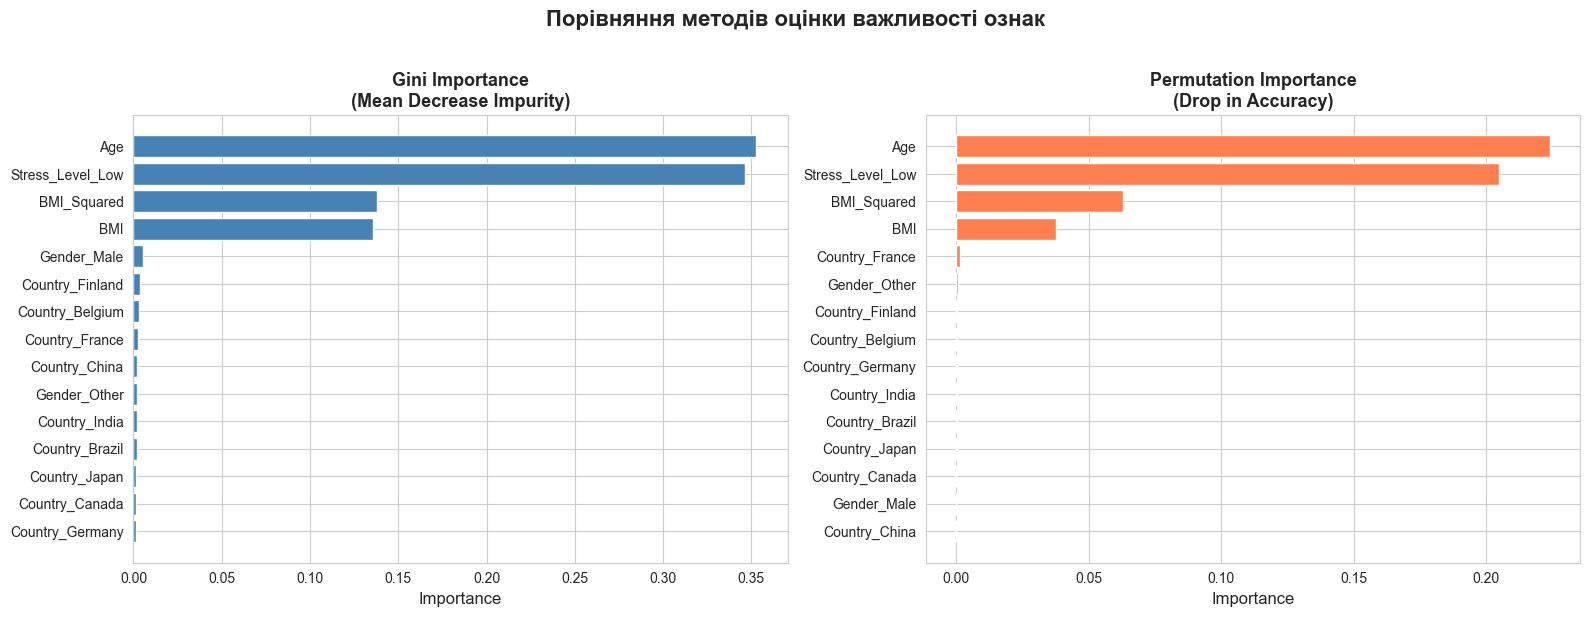


📊 Аналіз:
  Gini: Найважливіша — Age
  Permutation: Найважливіша — Age


In [15]:
# Обчислення Permutation Importance
print("🔄 Обчислення Permutation Importance...")
perm_importance = permutation_importance(rf_selected, X_test_selected, y_test_eng, 
                                         n_repeats=10, random_state=42, n_jobs=-1)

print("✓ Permutation Importance обчислено")

# Візуалізація
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Gini Importance
gini_imp = rf_selected.feature_importances_
sorted_idx_gini = gini_imp.argsort()[::-1]

axes[0].barh(range(len(selected_features)), gini_imp[sorted_idx_gini], color='steelblue')
axes[0].set_yticks(range(len(selected_features)))
axes[0].set_yticklabels([selected_features[i] for i in sorted_idx_gini], fontsize=10)
axes[0].set_xlabel('Importance', fontsize=12)
axes[0].set_title('Gini Importance\n(Mean Decrease Impurity)', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()

# 2. Permutation Importance
perm_imp = perm_importance.importances_mean
sorted_idx_perm = perm_imp.argsort()[::-1]

axes[1].barh(range(len(selected_features)), perm_imp[sorted_idx_perm], color='coral')
axes[1].set_yticks(range(len(selected_features)))
axes[1].set_yticklabels([selected_features[i] for i in sorted_idx_perm], fontsize=10)
axes[1].set_xlabel('Importance', fontsize=12)
axes[1].set_title('Permutation Importance\n(Drop in Accuracy)', fontsize=13, fontweight='bold')
axes[1].invert_yaxis()

plt.suptitle('Порівняння методів оцінки важливості ознак', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n📊 Аналіз:")
print(f"  Gini: Найважливіша — {selected_features[sorted_idx_gini[0]]}")
print(f"  Permutation: Найважливіша — {selected_features[sorted_idx_perm[0]]}")

## Висновки та Аналіз

### Основні результати

У цій лабораторній роботі була реалізована повна система аналізу дерев рішень для класифікації, включаючи:

1. **Власну реалізацію MyDecisionTree** з використанням Gini Index та обчисленням feature importance
2. **Cost-Complexity Pruning** для уникнення перенавчання
3. **Порівняння з sklearn моделями** (DecisionTree та RandomForest)
4. **Інженерію ознак та Feature Selection** для покращення якості моделі

### Теоретичні аспекти

**Формула важливості ознак:**

Для вузла $k$ важливість ознаки $f$ обчислюється як:

$$\text{Importance}_{Node_k}(f) = \frac{n_k}{n_{total}} \cdot \left( \text{Gini}_k - \frac{n_{left}}{n_k} \cdot \text{Gini}_{left} - \frac{n_{right}}{n_k} \cdot \text{Gini}_{right} \right)$$

Загальна важливість ознаки:

$$\text{Importance}(f) = \frac{\sum_{\text{nodes where } f \text{ splits}} \text{Importance}_{Node_k}(f)}{\sum_{\text{all nodes}} \text{Importance}_{Node_k}}$$

### Практичні висновки

1. **MyDecisionTree vs sklearn:** Власна реалізація показала конкурентоспроможні результати, хоча sklearn оптимізованіший за швидкістю
2. **RandomForest перевага:** Ансамбль дерев показав кращу точність через зменшення variance
3. **Прунінг ефективність:** Cost-Complexity Pruning успішно зменшив кількість листів, покращивши узагальнення
4. **Feature Engineering вплив:** Створення нових ознак та відбір топ-k покращило якість моделі та зменшило розмірність